This notebook is meant to compare the different types of matrix decompositions used for training to see which one works best

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import covariance_emulator as ce
import time, sys, math
plt.rcParams['figure.facecolor'] = 'white'
sys.path.insert(1, '/home/jadamo/CovA-NN-Emulator')
from CovNet import Network_Features, Block_Decoder, Block_Encoder, Network_VAE, MatrixDataset, symmetric_log, symmetric_exp, try_gpu, VAE_loss, features_loss, corr_to_cov

In [14]:
N = 52500
N_test = int(N*0.1)
training_dir = "/home/jadamo/CovA-NN-Emulator/Data/Training-Set/"
data_dir =  "/home/jadamo/CovA-NN-Emulator/Data/"
PCA_dir = "/home/jadamo/CovA-NN-Emulator/Data/PCA-Set/"
BOSS_dir = "/home/jadamo/CovA-NN-Emulator/Data/BOSS-DR12/"
CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"

In [3]:
# data and model vectors for chi squared calculations
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')

xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = xi_hat - xi_pi

def chi_squared(C, x):
    P = np.linalg.inv(C)
    return np.matmul(x.T, np.matmul(P, x))

We have 3 sets of networks to laod in. 1) networks with no extra data decomposition, 2) networks with Cholesky decomposition, and 3) networks with correlation matrix decomposition

In [4]:
VAE_vanilla     = Network_VAE().to(try_gpu());  VAE_vanilla.eval()
VAE_cholesky    = Network_VAE().to(try_gpu());  VAE_cholesky.eval()
VAE_correlation = Network_VAE().to(try_gpu());  VAE_correlation.eval()
decoder_vanilla     = Block_Decoder().to(try_gpu());   decoder_vanilla.eval()
decoder_cholesky    = Block_Decoder().to(try_gpu());   decoder_cholesky.eval()
decoder_correlation = Block_Decoder().to(try_gpu());   decoder_correlation.eval()
net_vanilla     = Network_Features(6, 10).to(try_gpu())
net_cholesky    = Network_Features(6, 10).to(try_gpu())
net_correlation = Network_Features(6, 10).to(try_gpu())

VAE_vanilla.load_state_dict(torch.load(data_dir+'No-decomp/network-VAE.params'))
VAE_cholesky.load_state_dict(torch.load(data_dir+'Cholesky-decomp/network-VAE.params'))
VAE_correlation.load_state_dict(torch.load(data_dir+'Correlation-decomp/network-VAE.params'))
decoder_vanilla.load_state_dict(VAE_vanilla.Decoder.state_dict())
decoder_cholesky.load_state_dict(VAE_cholesky.Decoder.state_dict())
decoder_correlation.load_state_dict(VAE_correlation.Decoder.state_dict())
net_vanilla.load_state_dict(torch.load(data_dir+"No-decomp/network-features.params"))
net_cholesky.load_state_dict(torch.load(data_dir+"Cholesky-decomp/network-features.params"))
net_correlation.load_state_dict(torch.load(data_dir+"Correlation-decomp/network-features.params"))

<All keys matched successfully>

In [5]:
# load the test set
t1 = time.time()
test_data = MatrixDataset(training_dir, N_test, int(N*0.9), False, False, False)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Now let's setup the PCA emulator

In [15]:
N_C = 100
C_PCA = np.zeros((N_C, 100, 100))
params_PCA = np.zeros((N_C, 6))
for i in range(N_C):
    temp = np.load(PCA_dir+"CovA-"+f'{i:04d}'+".npz")
    params_PCA[i] = np.delete(temp["params"], 4)
    C_PCA[i] = torch.from_numpy(temp["C"])
    
    # if the matrix doesn't match the transpose close enough, manually flip over the diagonal
    try:
        np.testing.assert_allclose(C_PCA[i], C_PCA[i].T, err_msg="covariance must match transpose")
    except AssertionError:
        print("matrix", i, "has high assymetry!")
        L = np.tril(C_PCA[i])
        U = np.tril(C_PCA[i], k=-1).T
        C_PCA[i] = L + U

matrix 14 has high assymetry!
matrix 20 has high assymetry!
matrix 52 has high assymetry!
matrix 73 has high assymetry!
matrix 74 has high assymetry!
matrix 83 has high assymetry!
matrix 91 has high assymetry!


In [16]:
Emu = ce.CovEmu(params_PCA, C_PCA, NPC_D=20, NPC_L=20)

Now let's calculate the $\chi^2$ errors for each of these networks and the PCA emulator

In [17]:
t1 = time.time()
error_vanilla, error_cholesky, error_correlation, error_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
for idx in range(N_test):
    C = test_data[idx][1]
    params = test_data[idx][0]
    
    features = net_vanilla(params);     C_vanilla = decoder_vanilla(features.view(1,10)).view(100, 100)
    C_vanilla = symmetric_exp(C_vanilla)
    features = net_cholesky(params);    C_cholesky = decoder_cholesky(features.view(1,10)).view(100, 100)
    C_cholesky = torch.matmul(symmetric_exp(C_cholesky), torch.t(symmetric_exp(C_cholesky)))
    features = net_correlation(params); C_correlation = decoder_correlation(features.view(1,10)).view(100, 100)
    C_correlation = corr_to_cov(C_correlation)
    C_PCA = Emu.predict(params.to("cpu").detach().numpy())
    
    chisq = chi_squared(C.cpu(), x)
    chisq_vanilla = chi_squared(C_vanilla.to("cpu").detach().numpy(), x)
    chisq_cholesky = chi_squared(C_cholesky.to("cpu").detach().numpy(), x)
    chisq_correlation = chi_squared(C_correlation.to("cpu").detach().numpy(), x)
    chisq_PCA = chi_squared(C_PCA, x)
    
    error_vanilla[idx] = abs(chisq - chisq_vanilla)
    error_cholesky[idx] = abs(chisq - chisq_cholesky)
    error_correlation[idx] = abs(chisq - chisq_correlation)
    error_PCA[idx] = abs(chisq - chisq_PCA)
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 4 minutes 49.42 seconds


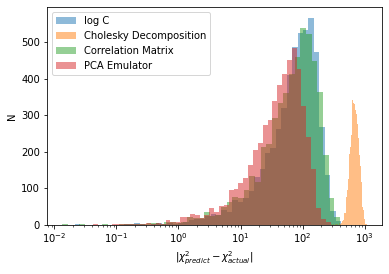

In [75]:
plt.hist(error_vanilla, bins=np.logspace(np.log10(np.amin(error_vanilla)), np.log10(np.amax(error_vanilla)), 50), alpha=0.5, label="log C")
plt.hist(error_cholesky, bins=np.logspace(np.log10(np.amin(error_cholesky)), np.log10(np.amax(error_cholesky)), 50), alpha=0.5, label="Cholesky Decomposition")
plt.hist(error_correlation, bins=np.logspace(np.log10(np.amin(error_correlation)), np.log10(np.amax(error_correlation)), 50), alpha=0.5, label="Correlation Matrix")
plt.hist(error_PCA, bins=np.logspace(np.log10(np.amin(error_PCA)), np.log10(np.amax(error_PCA)), 50), alpha=0.5, label="PCA Emulator")
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()

Let's look at each network on an individual matrix level to see how they're doing

Indexes:666, 2118


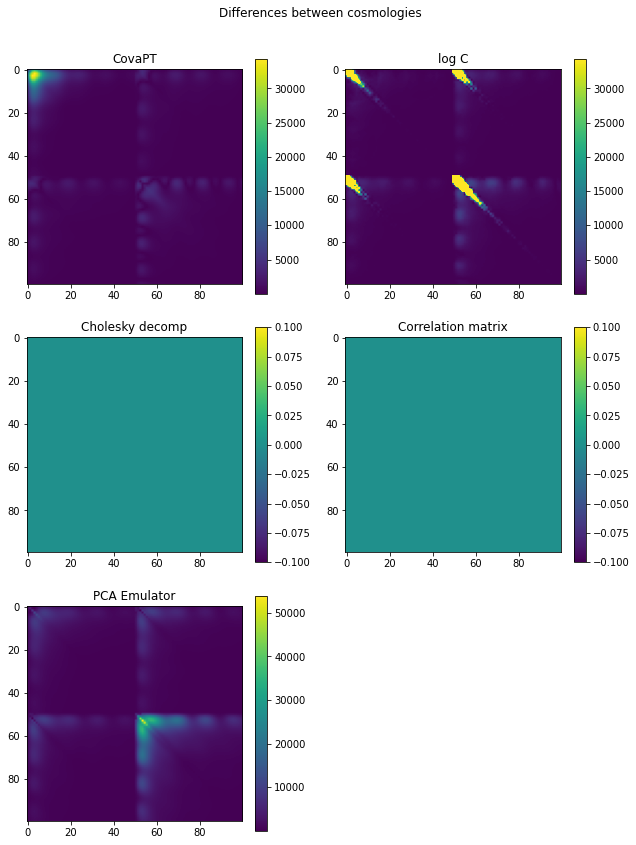

In [74]:
# Check that matrices with 2 different cosmologies are different
idx1 = np.random.randint(0, N_test)
idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
C_1 = test_data[idx1][1]; C_2 = test_data[idx2][1]

features = net_vanilla(params1);     C_vanilla1 = decoder_vanilla(features.view(1,10)).view(100, 100)
features = net_vanilla(params2);     C_vanilla2 = decoder_vanilla(features.view(1,10)).view(100, 100)
C_vanilla1 = symmetric_exp(C_vanilla1);  C_vanilla2 = symmetric_exp(C_vanilla2)
features = net_cholesky(params1);    C_cholesky1 = decoder_cholesky(features.view(1,10)).view(100, 100)
features = net_cholesky(params2);    C_cholesky2 = decoder_cholesky(features.view(1,10)).view(100, 100)
C_cholesky1 = torch.matmul(symmetric_exp(C_cholesky1), torch.t(symmetric_exp(C_cholesky1)))
C_cholesky2 = torch.matmul(symmetric_exp(C_cholesky2), torch.t(symmetric_exp(C_cholesky2)))
features = net_correlation(params1); C_correlation1 = decoder_correlation(features.view(1,10)).view(100, 100)
features = net_correlation(params2); C_correlation2 = decoder_correlation(features.view(1,10)).view(100, 100)
C_correlation1 = corr_to_cov(C_correlation1); C_correlation2 = corr_to_cov(C_correlation2)
C_PCA1 = Emu.predict(params1.to("cpu").detach().numpy())
C_PCA2 = Emu.predict(params2.to("cpu").detach().numpy())

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:"+ str(idx1) +",", idx2)
fig, axs = plt.subplots(3, 2, figsize=(9,12))
fig.suptitle("Differences between cosmologies")
axs[0,0].set_title("CovaPT")
axs[0,1].set_title("log C")
axs[1,0].set_title("Cholesky decomp")
axs[1,1].set_title("Correlation matrix")
axs[2,0].set_title("PCA Emulator")
m = axs[0,0].imshow(abs(C_1 - C_2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[0,0])
m = axs[0,1].imshow(abs(C_vanilla1 - C_vanilla2).cpu().detach().numpy(), vmin=torch.amin(abs(C_1 - C_2)), vmax=torch.amax(abs(C_1 - C_2)))
fig.colorbar(m, ax=axs[0,1])
m = axs[1,0].imshow(abs(C_cholesky1 - C_cholesky2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[1,0])
m = axs[1,1].imshow(abs(C_correlation1 - C_correlation2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[1,1])
m = axs[2,0].imshow(abs(C_PCA1 - C_PCA2))
fig.colorbar(m, ax=axs[2,0])

axs[-1, -1].axis('off')
fig.tight_layout()
fig.subplots_adjust(top=0.92)

Let's also look at the training + validation loss graphs to make sure nothing fishy is going on

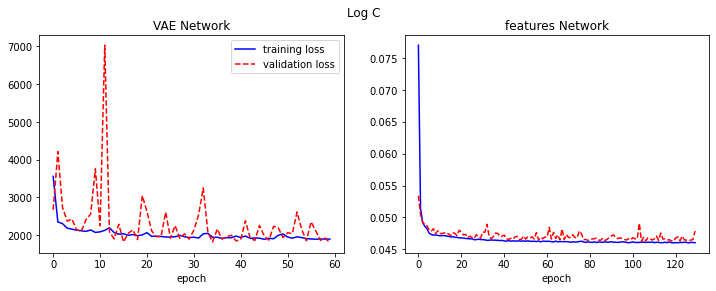

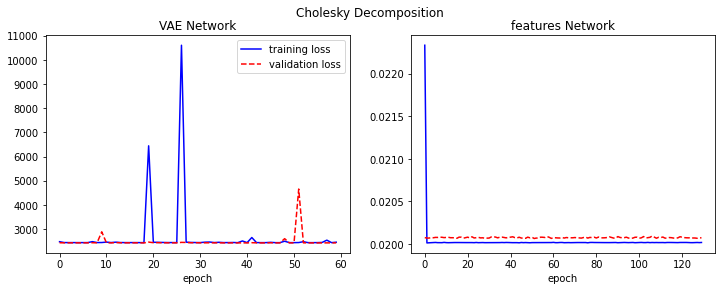

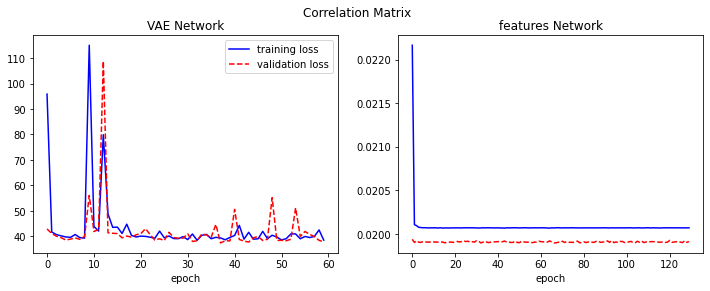

In [58]:
train_loss_vanilla = torch.load(data_dir+"No-decomp/train_loss.dat")
valid_loss_vanilla = torch.load(data_dir+"No-decomp/valid_loss.dat")
train_loss_cholesky = torch.load(data_dir+"Cholesky-decomp/train_loss.dat")
valid_loss_cholesky = torch.load(data_dir+"Cholesky-decomp/valid_loss.dat")
train_loss_correlation = torch.load(data_dir+"Correlation-decomp/train_loss.dat")
valid_loss_correlation = torch.load(data_dir+"Correlation-decomp/valid_loss.dat")
train_loss_f_vanilla = torch.load(data_dir+"No-decomp/train_loss-features.dat")
valid_loss_f_vanilla = torch.load(data_dir+"No-decomp/valid_loss-features.dat")
train_loss_f_cholesky = torch.load(data_dir+"Cholesky-decomp/train_loss-features.dat")
valid_loss_f_cholesky = torch.load(data_dir+"Cholesky-decomp/valid_loss-features.dat")
train_loss_f_correlation = torch.load(data_dir+"Correlation-decomp/train_loss-features.dat")
valid_loss_f_correlation = torch.load(data_dir+"Correlation-decomp/valid_loss-features.dat")

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Log C")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(60), train_loss_vanilla, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_vanilla, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_vanilla, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_vanilla, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Cholesky Decomposition")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(60), train_loss_cholesky, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_cholesky, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_cholesky, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_cholesky, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Correlation Matrix")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(60), train_loss_correlation, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_correlation, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_correlation, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_correlation, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

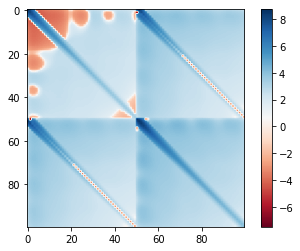

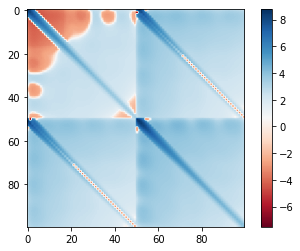

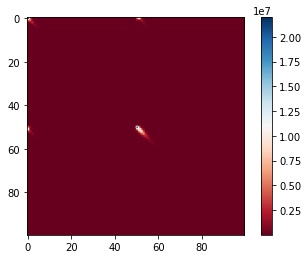

In [69]:
plt.imshow(symmetric_log(C_vanilla1).cpu().detach().numpy(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(symmetric_log(C_vanilla2).cpu().detach().numpy(), cmap="RdBu")
cbar = plt.colorbar()